**Name       : Maundri Prihanggo & Pinelopi-Eirini Kountouri**  
**Student ID : 5151279 & 5386454**

## Overview  

The data given is Sentinel-2 image with level 2A, acquired over tile 31UET. It has 3 different spatial resolutions (10m , 20m, 60m). This report is only focused on the classification of 10 m (second part) and 60 m (first part) spatial resolution.

## Import Module

Import key module for the coding use in 10 m and 60 m spatial resolution.

In [1]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
from sklearn import metrics
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image

## Import Images, Create Array and Compute K-means Value (60 m Resolution)  

K-means algorithm is a widely used method in clustering techniques.It divides the number of observations into k clusters (in this case we devided it into 3,5 and 9 clusters) which each observation belongs to the cluster with the nearest mean. This method was selected for its relatively simple implementation and decent result, however the disavantages behind this algorithm are the cost of time calculation especially when the number of clusters is considerably high.

Bands in 60 m spatial resolution containing all components of the 20 m product resampled to 60 m and additionally the bands 1 and 9. The cirrus band 10 is omitted, as it does not contain surface information.

Before deciding in which combination of bands we are going to be focused on, it is a certainly priority to define how many clusters we want to build and perceive what they represent. There are five clusters we want to create using k-means, namely vegetation, urban, soil, water and road. It is assumed that these five clusters are the easiest object that can be clustered/segmented.

Therefore, we are focusing on band 2,3,4,8 and 11. Since, band 2 (blue), 3 (green) and 4 (red) are primary colour bands, the use of these bands is consdered mandatory. Each Band 2, 3, 4 and 8(Near Infra Red/NIR) have wavelength from 400 nm to 900 nm. Band 11 (Short Wave Infra Red/SWIR) has central wavelength of 1610 nm. This combination between 5 bands (band 2,3,4,8 and 11) probably make a good result in clustering and interpretaion of the image.

In [2]:
imagePath = './S2A_MSIL2A_20200530T105031_N0214_R051_T31UET_20200530T134211.SAFE/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R60m/'
band2_60m = rasterio.open (imagePath + 'T31UET_20200530T105031_B02_60m.jp2', driver = 'JP2OpenJPEG') #blue
band3_60m = rasterio.open (imagePath + 'T31UET_20200530T105031_B03_60m.jp2', driver = 'JP2OpenJPEG') #green
band4_60m = rasterio.open (imagePath + 'T31UET_20200530T105031_B04_60m.jp2', driver = 'JP2OpenJPEG') #red
band8_60m = rasterio.open (imagePath + 'T31UET_20200530T105031_B8A_60m.jp2', driver = 'JP2OpenJPEG') #nir
band11_60m = rasterio.open (imagePath + 'T31UET_20200530T105031_B11_60m.jp2', driver = 'JP2OpenJPEG') #swir

b2 = np.empty((band2_60m.height, band2_60m.width, band2_60m.count), band2_60m.meta['dtype'])
b3 = np.empty((band3_60m.height, band3_60m.width, band3_60m.count), band3_60m.meta['dtype'])
b4 = np.empty((band4_60m.height, band4_60m.width, band4_60m.count), band4_60m.meta['dtype'])
b8 = np.empty((band8_60m.height, band8_60m.width, band8_60m.count), band8_60m.meta['dtype'])
b11 = np.empty((band11_60m.height, band11_60m.width, band11_60m.count), band11_60m.meta['dtype'])

for band in range(b2.shape[2]):
    b2[:,:,band] = band2_60m.read(band+1)
    
for band in range(b3.shape[2]):
    b3[:,:,band] = band3_60m.read(band+1)
    
for band in range(b4.shape[2]):
    b4[:,:,band] = band4_60m.read(band+1)
    
for band in range(b8.shape[2]):
    b8[:,:,band] = band8_60m.read(band+1)
    
for band in range(b11.shape[2]):
    b11[:,:,band] = band11_60m.read(band+1)
    
b2_1d=(b2[:,:,:3].reshape((b2.shape[0]*b2.shape[1],b2.shape[2]))).flatten ('F')
b3_1d=(b3[:,:,:3].reshape((b3.shape[0]*b3.shape[1],b3.shape[2]))).flatten ('F')
b4_1d=(b4[:,:,:3].reshape((b4.shape[0]*b4.shape[1],b4.shape[2]))).flatten ('F')
b8_1d=(b8[:,:,:3].reshape((b8.shape[0]*b8.shape[1],b8.shape[2]))).flatten ('F')
b11_1d=(b11[:,:,:3].reshape((b11.shape[0]*b11.shape[1],b11.shape[2]))).flatten ('F')

b23 = np.vstack ((b2_1d, b3_1d))
b23 = np.transpose(b23)
b24 = np.vstack ((b2_1d, b4_1d))
b24 = np.transpose(b24)
b34 = np.vstack ((b3_1d, b4_1d))
b34 = np.transpose(b34)
b28 = np.vstack ((b2_1d, b8_1d))
b28 = np.transpose(b28)
b38 = np.vstack ((b3_1d, b8_1d))
b38 = np.transpose(b38)
b48 = np.vstack ((b4_1d, b8_1d))
b48 = np.transpose(b48)
b21 = np.vstack ((b2_1d, b11_1d))
b21 = np.transpose(b21)
b31 = np.vstack ((b3_1d, b11_1d))
b31 = np.transpose(b31)
b41 = np.vstack ((b4_1d, b11_1d))
b41 = np.transpose(b41)
b81 = np.vstack ((b8_1d, b11_1d))
b81 = np.transpose(b81)


k23 = KMeans(n_clusters=5, random_state=170).fit_predict(b23)
y23 = k23.reshape(1830,1830)
k24 = KMeans(n_clusters=5, random_state=170).fit_predict(b24)
y24 = k24.reshape(1830,1830)
k34 = KMeans(n_clusters=5, random_state=170).fit_predict(b34)
y34 = k34.reshape(1830,1830)
k28 = KMeans(n_clusters=5, random_state=170).fit_predict(b28)
y28 = k28.reshape(1830,1830)
k38 = KMeans(n_clusters=5, random_state=170).fit_predict(b38)
y38 = k38.reshape(1830,1830)
k48 = KMeans(n_clusters=5, random_state=170).fit_predict(b48)
y48 = k48.reshape(1830,1830)
k21 = KMeans(n_clusters=5, random_state=170).fit_predict(b21)
y21 = k21.reshape(1830,1830)
k31 = KMeans(n_clusters=5, random_state=170).fit_predict(b31)
y31 = k31.reshape(1830,1830)
k41 = KMeans(n_clusters=5, random_state=170).fit_predict(b41)
y41 = k41.reshape(1830,1830)
k81 = KMeans(n_clusters=5, random_state=170).fit_predict(b81)
y81 = k81.reshape(1830,1830)

k123 = KMeans(n_clusters=3, random_state=170).fit_predict(b23)
y123 = k123.reshape(1830,1830)
k124 = KMeans(n_clusters=3, random_state=170).fit_predict(b24)
y124 = k124.reshape(1830,1830)
k134 = KMeans(n_clusters=3, random_state=170).fit_predict(b34)
y134 = k134.reshape(1830,1830)
k128 = KMeans(n_clusters=3, random_state=170).fit_predict(b28)
y128 = k128.reshape(1830,1830)
k138 = KMeans(n_clusters=3, random_state=170).fit_predict(b38)
y138 = k138.reshape(1830,1830)
k148 = KMeans(n_clusters=3, random_state=170).fit_predict(b48)
y148 = k148.reshape(1830,1830)
k121 = KMeans(n_clusters=3, random_state=170).fit_predict(b21)
y121 = k121.reshape(1830,1830)
k131 = KMeans(n_clusters=3, random_state=170).fit_predict(b31)
y131 = k131.reshape(1830,1830)
k141 = KMeans(n_clusters=3, random_state=170).fit_predict(b41)
y141 = k141.reshape(1830,1830)
k181 = KMeans(n_clusters=3, random_state=170).fit_predict(b81)
y181 = k181.reshape(1830,1830)

k223 = KMeans(n_clusters=9, random_state=170).fit_predict(b23)
y223 = k223.reshape(1830,1830)
k224 = KMeans(n_clusters=9, random_state=170).fit_predict(b24)
y224 = k224.reshape(1830,1830)
k234 = KMeans(n_clusters=9, random_state=170).fit_predict(b34)
y234 = k234.reshape(1830,1830)
k228 = KMeans(n_clusters=9, random_state=170).fit_predict(b28)
y228 = k228.reshape(1830,1830)
k238 = KMeans(n_clusters=9, random_state=170).fit_predict(b38)
y238 = k238.reshape(1830,1830)
k248 = KMeans(n_clusters=9, random_state=170).fit_predict(b48)
y248 = k248.reshape(1830,1830)
k221 = KMeans(n_clusters=9, random_state=170).fit_predict(b21)
y221 = k221.reshape(1830,1830)
k231 = KMeans(n_clusters=9, random_state=170).fit_predict(b31)
y231 = k231.reshape(1830,1830)
k241 = KMeans(n_clusters=9, random_state=170).fit_predict(b41)
y241 = k241.reshape(1830,1830)
k281 = KMeans(n_clusters=9, random_state=170).fit_predict(b81)
y281 = k281.reshape(1830,1830)

## Scatter Plot of K-means Value (60 m Resolution)  
Order to read the figures 
- first figure showing 5 clusters with order from left to right, first row : bands 2-3, band 2-4, second row : bands 3-4, bands 2-8, third row : bands 3-8, bands 4-8, fourth row : bands 2-11, bands 3-11, fifth row : bansd 4-11, bands 8-11 
- second figure showing 3 clusters with order from left to right, first row : bands 2-3, bands 2-4, second row : bands 3-4, bands 2-8, third row : band 3-8, band 4-8, fourth row : band 2-11, band 3-11, fifth row : band 4-11, band 8-11 
- third figure showing 9 clusters with order from left to right, first row : band 2-3, band 2-4, second row : band 3-4, band 2-8, third row : bands 3-8, bands 4-8, fourth row : bands 2-11, bands 3-11, fifth row : bands 4-11, bands 8-11 

The figures below depict the differentiation of scatter plot between two bands. It is known that in each scatter plot is displayed the number of clusters between two bands. In this case 3 figures were created, the first one made consists of 5 clusters, the second one with 3 clusters and the last one with 9 clusters.

From the figures below, it was observed that the higher number of clusters, the higher overlapping between the bands. Thus,the preferable number of clusters selected was five in order to avoid the loss of information due to the overlapping.

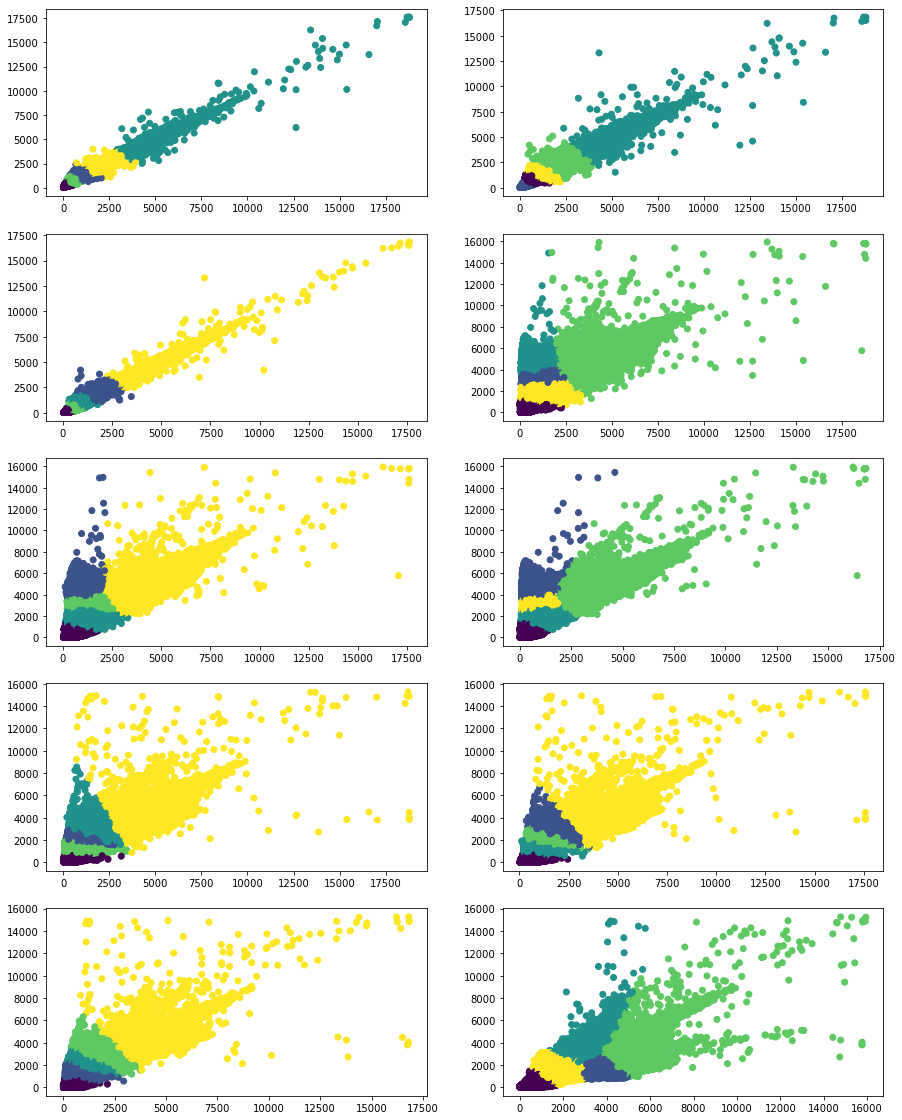

In [3]:
fig = plt.figure (figsize = (15,20))
ax1 = fig.add_subplot(5,2,1)
ax2 = fig.add_subplot(5,2,2)
ax3 = fig.add_subplot(5,2,3)
ax4 = fig.add_subplot(5,2,4)
ax5 = fig.add_subplot(5,2,5)
ax6 = fig.add_subplot(5,2,6)
ax7 = fig.add_subplot(5,2,7)
ax8 = fig.add_subplot(5,2,8)
ax9 = fig.add_subplot(5,2,9)
ax10 = fig.add_subplot(5,2,10)

ax1.scatter(b2_1d, b3_1d, c=k23)
ax2.scatter(b2_1d, b4_1d, c=k24)
ax3.scatter(b3_1d, b4_1d, c=k34)
ax4.scatter(b2_1d, b8_1d, c=k28)
ax5.scatter(b3_1d, b8_1d, c=k38)
ax6.scatter(b4_1d, b8_1d, c=k48)
ax7.scatter(b2_1d, b11_1d, c=k21)
ax8.scatter(b3_1d, b11_1d, c=k31)
ax9.scatter(b4_1d, b11_1d, c=k41)
ax10.scatter(b8_1d, b11_1d, c=k81)

plt.show()

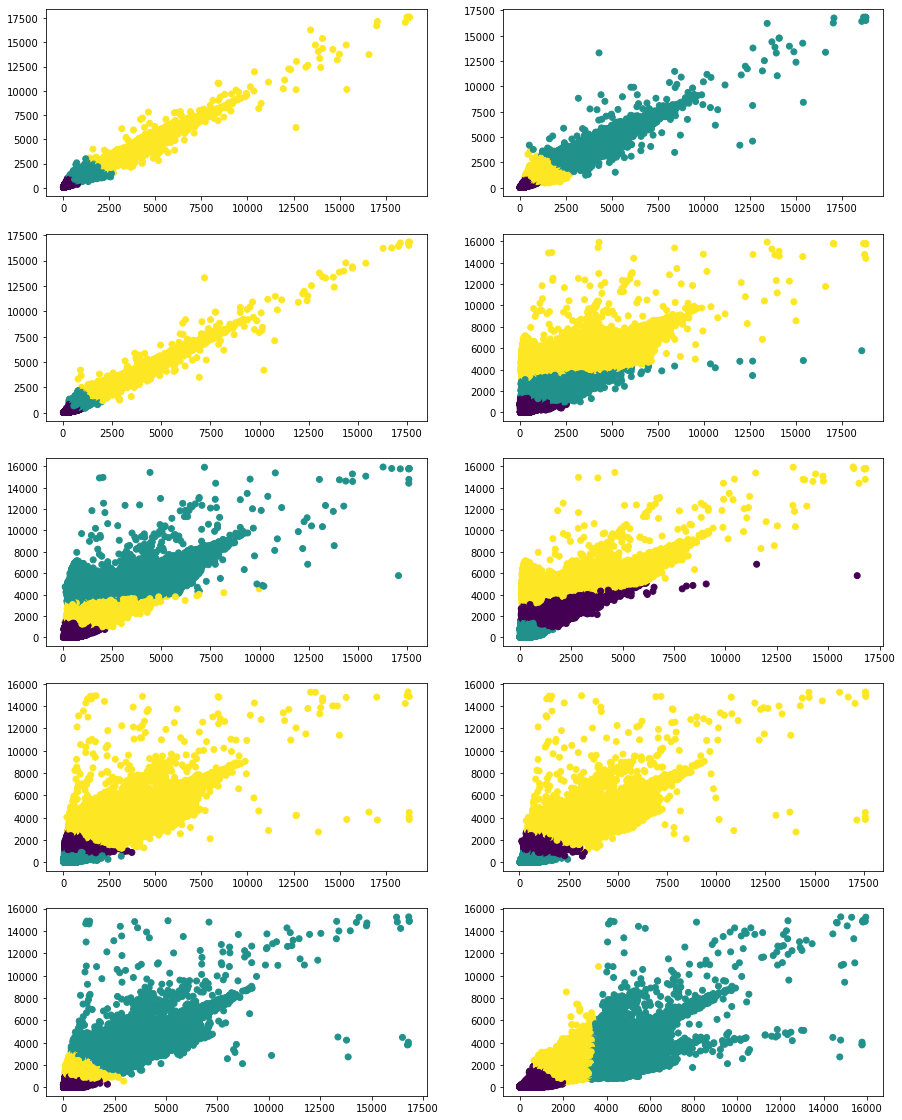

In [5]:
fig = plt.figure (figsize = (15,20))
ax1 = fig.add_subplot(5,2,1)
ax2 = fig.add_subplot(5,2,2)
ax3 = fig.add_subplot(5,2,3)
ax4 = fig.add_subplot(5,2,4)
ax5 = fig.add_subplot(5,2,5)
ax6 = fig.add_subplot(5,2,6)
ax7 = fig.add_subplot(5,2,7)
ax8 = fig.add_subplot(5,2,8)
ax9 = fig.add_subplot(5,2,9)
ax10 = fig.add_subplot(5,2,10)

ax1.scatter(b2_1d, b3_1d, c=k123)
ax2.scatter(b2_1d, b4_1d, c=k124)
ax3.scatter(b3_1d, b4_1d, c=k134)
ax4.scatter(b2_1d, b8_1d, c=k128)
ax5.scatter(b3_1d, b8_1d, c=k138)
ax6.scatter(b4_1d, b8_1d, c=k148)
ax7.scatter(b2_1d, b11_1d, c=k121)
ax8.scatter(b3_1d, b11_1d, c=k131)
ax9.scatter(b4_1d, b11_1d, c=k141)
ax10.scatter(b8_1d, b11_1d, c=k181)

plt.show()

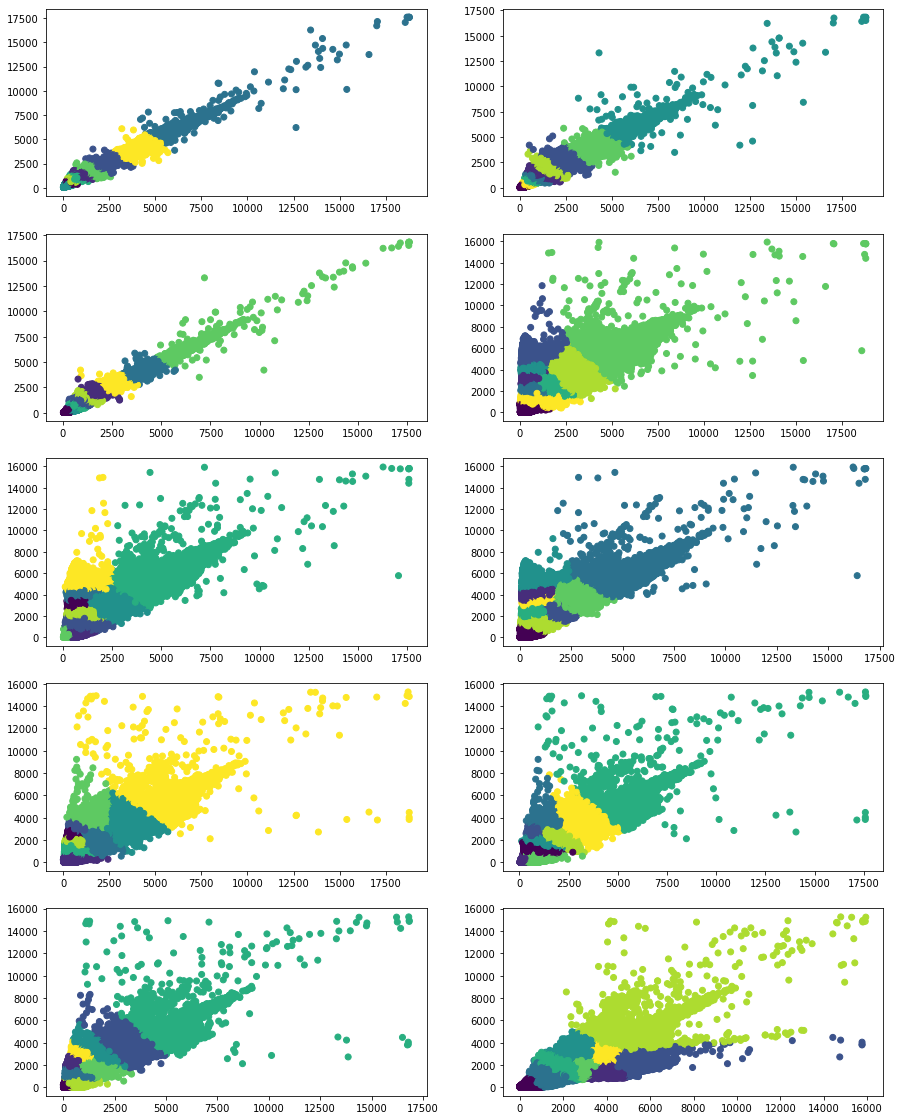

In [6]:
fig = plt.figure (figsize = (15,20))
ax1 = fig.add_subplot(5,2,1)
ax2 = fig.add_subplot(5,2,2)
ax3 = fig.add_subplot(5,2,3)
ax4 = fig.add_subplot(5,2,4)
ax5 = fig.add_subplot(5,2,5)
ax6 = fig.add_subplot(5,2,6)
ax7 = fig.add_subplot(5,2,7)
ax8 = fig.add_subplot(5,2,8)
ax9 = fig.add_subplot(5,2,9)
ax10 = fig.add_subplot(5,2,10)

ax1.scatter(b2_1d, b3_1d, c=k223)
ax2.scatter(b2_1d, b4_1d, c=k224)
ax3.scatter(b3_1d, b4_1d, c=k234)
ax4.scatter(b2_1d, b8_1d, c=k228)
ax5.scatter(b3_1d, b8_1d, c=k238)
ax6.scatter(b4_1d, b8_1d, c=k248)
ax7.scatter(b2_1d, b11_1d, c=k221)
ax8.scatter(b3_1d, b11_1d, c=k231)
ax9.scatter(b4_1d, b11_1d, c=k241)
ax10.scatter(b8_1d, b11_1d, c=k281)

plt.show()

## Pearson Correlation Between 2 Bands (60 m Resolution)

Pearson correlation was used to quantify the strength of relationship between two bands. If the value of the pearson correlation is getting closer to 1, then the correlation between 2 bands are relatively more correlated. In other words, the combination of the bands calculated the higher pearson correlation should be avoid to be sellected. The results of pearson correlation shown that the combination between bands 2-3, 2-4, and 3-4 had the highest pearson correlation value (almost 1) while the lowest was between bands 2-8. Low values also observed  between bands 3-8 and 4-8 with a value around to 0.6. It was assumed that the lower values of pearson correlation correspond in a better band combination.

In [ ]:
from scipy import stats

b2_1d_n = (b2_1d - b2_1d.mean())/b2_1d.std()
b3_1d_n = (b3_1d - b3_1d.mean())/b3_1d.std()
b4_1d_n = (b4_1d - b4_1d.mean())/b4_1d.std()
b8_1d_n = (b8_1d - b8_1d.mean())/b8_1d.std()
b11_1d_n = (b11_1d - b11_1d.mean())/b11_1d.std()

pecoef_23 = stats.pearsonr(b2_1d_n,b3_1d_n)
pecoef_24 = stats.pearsonr(b2_1d_n,b4_1d_n)
pecoef_34 = stats.pearsonr(b3_1d_n,b4_1d_n)
pecoef_28 = stats.pearsonr(b2_1d_n,b8_1d_n)
pecoef_38 = stats.pearsonr(b3_1d_n,b8_1d_n)
pecoef_48 = stats.pearsonr(b4_1d_n,b8_1d_n)
pecoef_21 = stats.pearsonr(b2_1d_n,b11_1d_n)
pecoef_31 = stats.pearsonr(b3_1d_n,b11_1d_n)
pecoef_41 = stats.pearsonr(b4_1d_n,b11_1d_n)
pecoef_81 = stats.pearsonr(b8_1d_n,b11_1d_n)

print ("pearson correlation band 2-band 3 :", pecoef_23)
print ("pearson correlation band 2-band 4 :", pecoef_24)
print ("pearson correlation band 3-band 4 :", pecoef_34)
print ("pearson correlation band 2-band 8 :", pecoef_28)
print ("pearson correlation band 3-band 8 :", pecoef_38)
print ("pearson correlation band 4-band 8 :", pecoef_48)
print ("pearson correlation band 2-band 11 :", pecoef_21)
print ("pearson correlation band 3-band 11 :", pecoef_31)
print ("pearson correlation band 4-band 11 :", pecoef_41)
print ("pearson correlation band 8-band 11 :", pecoef_81)

## Display Clustered Image of K-means Value (60 m Resolution)  
Order to read the image 
- first image showing 5 clusters with order from left to right, first row : bands 2-3, band 2-4, second row : bands 3-4, bands 2-8, third row : bands 3-8, bands 4-8, fourth row : bands 2-11, bands 3-11, fifth row : bansd 4-11, bands 8-11 
- second image showing 3 clusters with order from left to right, first row : bands 2-3, bands 2-4, second row : bands 3-4, bands 2-8, third row : band 3-8, band 4-8, fourth row : band 2-11, band 3-11, fifth row : band 4-11, band 8-11 
- third image showing 9 clusters with order from left to right, first row : band 2-3, band 2-4, second row : band 3-4, band 2-8, third row : bands 3-8, bands 4-8, fourth row : bands 2-11, bands 3-11, fifth row : bands 4-11, bands 8-11 

At this step, in order to decide which image provides results closest to reality,they were performed comparisons both in the number of clusters and the different combination of bands. It was noticed that the higher number of cluster used, the more confused results gave because of the higher overlapping and the noise produced from the different colours of clusters. Furthermore, in case the number of clusters made was small (3 clusters), some information on the image was lost. To be more specific a lot of water was clustered on land area as it was depicted with the same colour on the image. Therefore, it was assumed that five clusters was sufficient for this image area.

From the visualisation of the image on the 5 clusters, it was shown that bands 2-3 and 3-4 seems incorrect because there was clustered area on the sea with the same colour with objects on the land. Therefore, it was assumed that the combination between primary colour bands is relatively not suitable. The better band combination is shown if we make combination between primary colour band (bands 2,3 and 4) and NIR/SWIR band (band 8 or band 11). This assumption is consistent with the lower values of pearson correlation, the better result of band combination.

If we want to make a better conclusion, we need to do field survey and compare between clustered area and the object in the real world. 

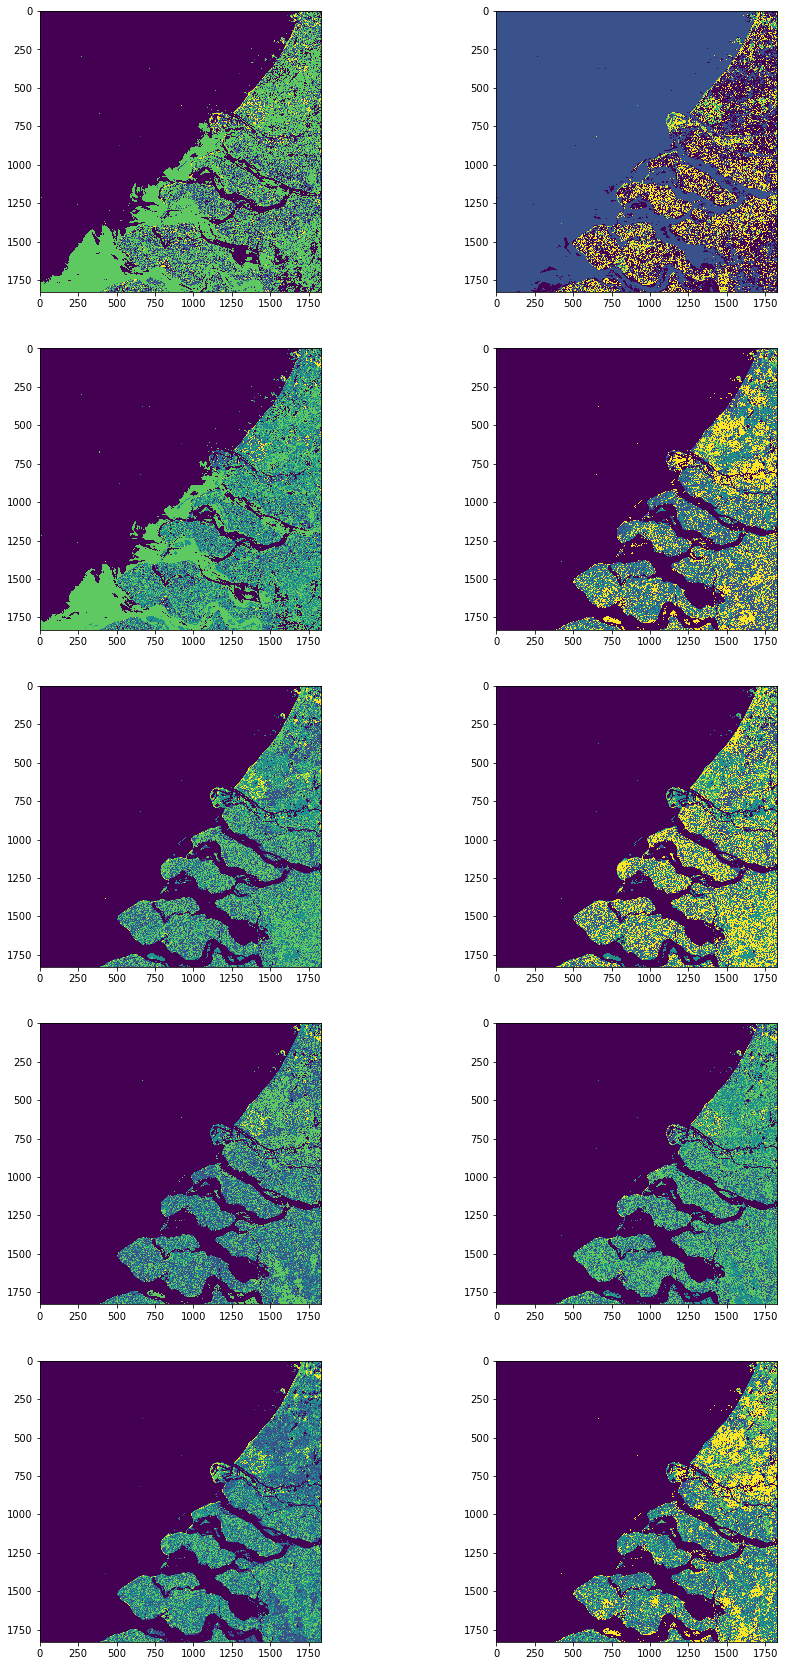

In [7]:
fig = plt.figure(figsize = (15,30))
ax1 = fig.add_subplot(5,2,1)
ax1.imshow(y23)
ax2 = fig.add_subplot(5,2,2)
ax2.imshow(y24)
ax3 = fig.add_subplot(5,2,3)
ax3.imshow(y34)
ax4 = fig.add_subplot(5,2,4)
ax4.imshow(y28)
ax5 = fig.add_subplot(5,2,5)
ax5.imshow(y38)
ax6 = fig.add_subplot(5,2,6)
ax6.imshow(y48)
ax7 = fig.add_subplot(5,2,7)
ax7.imshow(y21)
ax8 = fig.add_subplot(5,2,8)
ax8.imshow(y31)
ax9 = fig.add_subplot(5,2,9)
ax9.imshow(y41)
ax10 = fig.add_subplot(5,2,10)
ax10.imshow(y81)

plt.show()

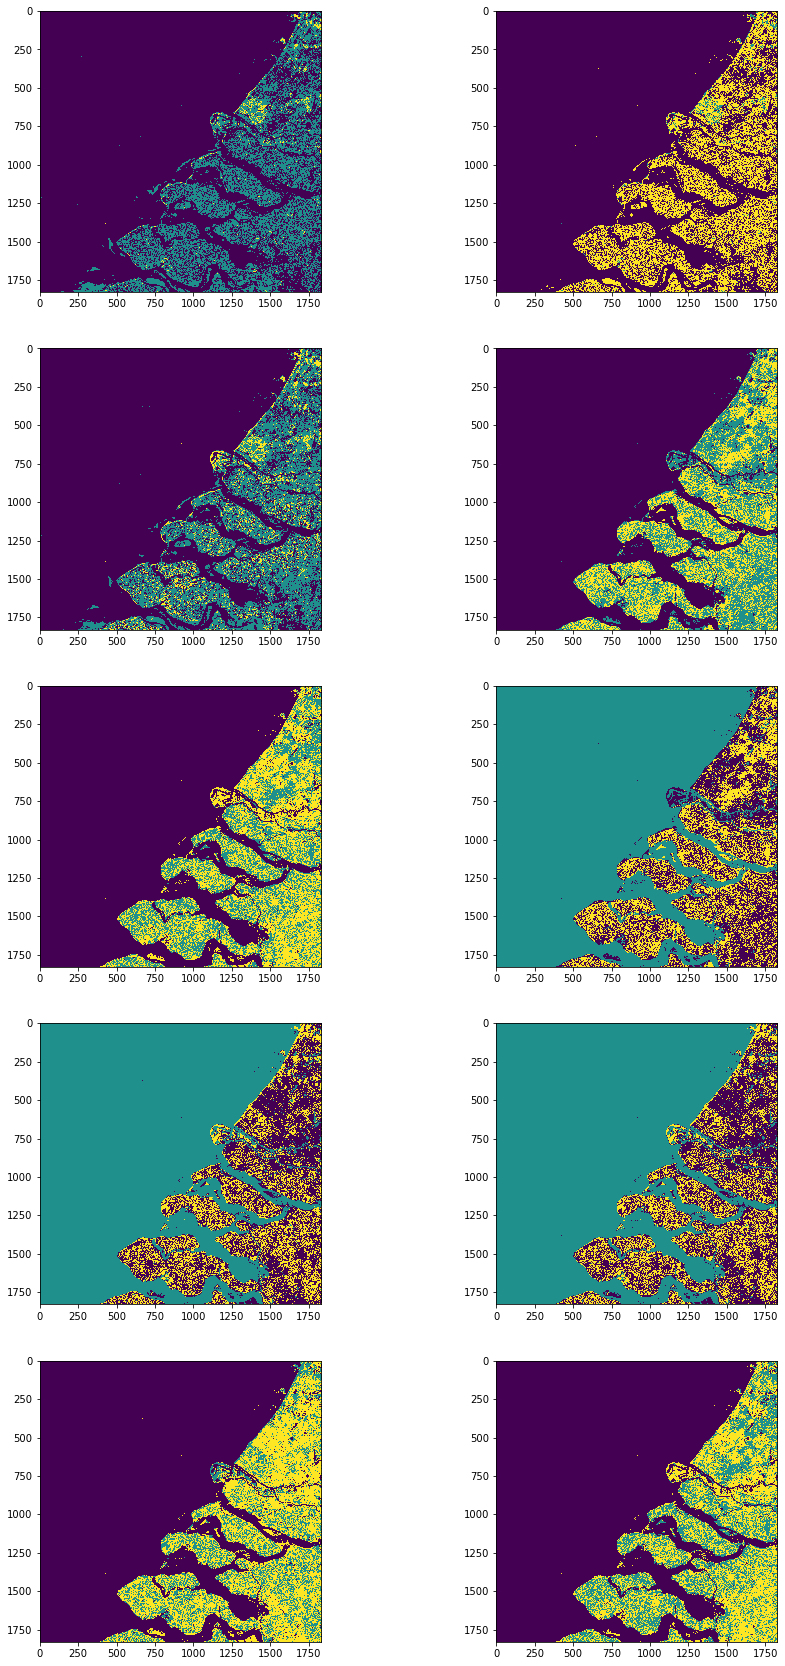

In [8]:
fig = plt.figure(figsize = (15,30))
ax1 = fig.add_subplot(5,2,1)
ax1.imshow(y123)
ax2 = fig.add_subplot(5,2,2)
ax2.imshow(y124)
ax3 = fig.add_subplot(5,2,3)
ax3.imshow(y134)
ax4 = fig.add_subplot(5,2,4)
ax4.imshow(y128)
ax5 = fig.add_subplot(5,2,5)
ax5.imshow(y138)
ax6 = fig.add_subplot(5,2,6)
ax6.imshow(y148)
ax7 = fig.add_subplot(5,2,7)
ax7.imshow(y121)
ax8 = fig.add_subplot(5,2,8)
ax8.imshow(y131)
ax9 = fig.add_subplot(5,2,9)
ax9.imshow(y141)
ax10 = fig.add_subplot(5,2,10)
ax10.imshow(y181)

plt.show()

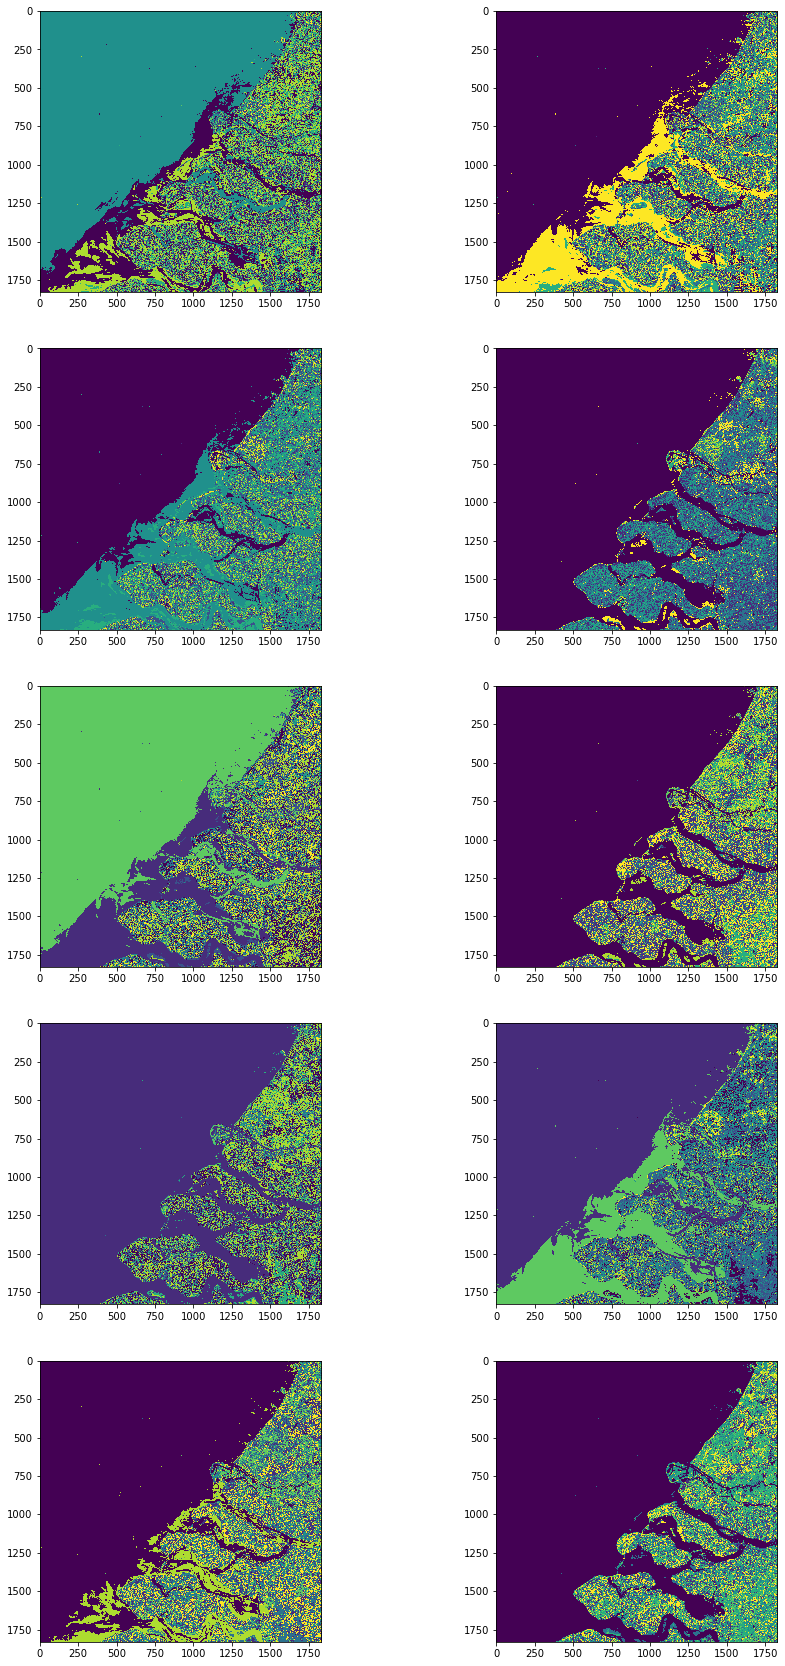

In [9]:
fig = plt.figure(figsize = (15,30))
ax1 = fig.add_subplot(5,2,1)
ax1.imshow(y223)
ax2 = fig.add_subplot(5,2,2)
ax2.imshow(y224)
ax3 = fig.add_subplot(5,2,3)
ax3.imshow(y234)
ax4 = fig.add_subplot(5,2,4)
ax4.imshow(y228)
ax5 = fig.add_subplot(5,2,5)
ax5.imshow(y238)
ax6 = fig.add_subplot(5,2,6)
ax6.imshow(y248)
ax7 = fig.add_subplot(5,2,7)
ax7.imshow(y221)
ax8 = fig.add_subplot(5,2,8)
ax8.imshow(y231)
ax9 = fig.add_subplot(5,2,9)
ax9.imshow(y241)
ax10 = fig.add_subplot(5,2,10)
ax10.imshow(y281)

plt.show()

## CDF Between 2 Bands (60 m Resolution)
This CDF plot shown the differences between the number of objects being clustered from each band combination for 5 clusters. The x-axis is the number of cluster, there are 5 cluster (cluster 0, 1, 2, 3, 4). The most siginificant is the number of objects in cluster 1 for band 2 and band 4 combination, these bands combination have more objects in cluster 1 than another cluster. Meanwhile another bands combination have a similar CDF plot. 


/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


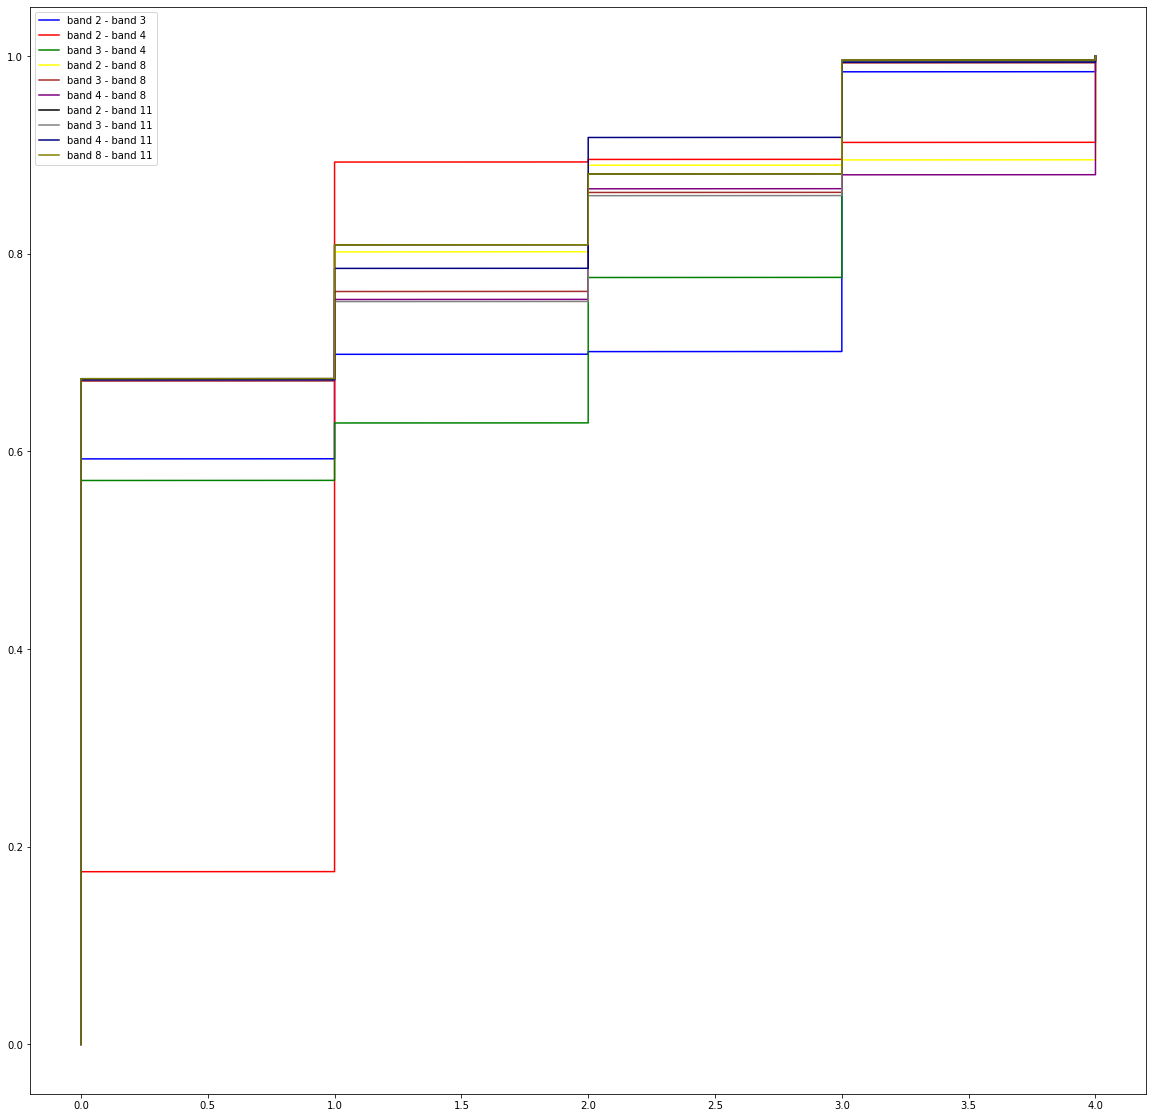

In [13]:
y23 = y23.flatten('F')
y23 = np.sort(y23)
a = 1. * np.arange(len(y23))/(len(y23) - 1)

y24 = y24.flatten('F')
y24 = np.sort(y24)
b = 1. * np.arange(len(y24))/(len(y24) - 1)

y34 = y34.flatten('F')
y34 = np.sort(y34)
c = 1. * np.arange(len(y34))/(len(y34) - 1)

y28 = y28.flatten ('F')
y28 = np.sort(y28)
d = 1. * np.arange(len(y28))/(len(y28) - 1)

y38 = y38.flatten ('F')
y38 = np.sort(y38)
e = 1. * np.arange(len(y38))/(len(y38) - 1)

y48 = y48.flatten ('F')
y48 = np.sort(y48)
f = 1. * np.arange(len(y48))/(len(y48) - 1)

y21 = y21.flatten ('F')
y21 = np.sort(y21)
g = 1. * np.arange(len(y21))/(len(y21) - 1)

y31 = y31.flatten ('F')
y31 = np.sort(y31)
h = 1. * np.arange(len(y31))/(len(y31) - 1)

y41 = y41.flatten ('F')
y41 = np.sort(y41)
i = 1. * np.arange(len(y41))/(len(y41) - 1)

y81 = y21.flatten ('F')
y81 = np.sort(y81)
j = 1. * np.arange(len(y81))/(len(y81) - 1)


plt.figure (figsize = (20,20))
plt.plot(y23, a, c= 'blue', label = 'band 2 - band 3')
plt.plot(y24, b, c= 'red', label = 'band 2 - band 4')
plt.plot(y34, c, c= 'green', label = 'band 3 - band 4')
plt.plot(y28, d, c= 'yellow', label = 'band 2 - band 8')
plt.plot(y38, e, c= 'brown', label = 'band 3 - band 8')
plt.plot(y48, f, c= 'purple', label = 'band 4 - band 8')
plt.plot(y21, g, c= 'black', label = 'band 2 - band 11')
plt.plot(y31, h, c= 'gray', label = 'band 3 - band 11')
plt.plot(y41, i, c= 'navy', label = 'band 4 - band 11')
plt.plot(y81, j, c= 'olive', label = 'band 8 - band 11')
plt.legend()
plt.show()

## Import Images, Create Array and Compute K-means Value (10 m Resolution)  

The same procedure with the '60 m resolution' was implemented but it was added one step more which is to create the subset of the whole 10 m resolution. The higher of resolution and the finer the grid is, the larger is the degree of recognizable details on true earth's surface. Therefore if we clustered all the image of 10 m resolution, it would take a longer time. We can see the step to create the subset by looking at the '##create subset##' on the code below.

In 10 m resolution, it has only 4 bands, they are band 2, 3, 4 and 8. It was selected to be 5 clusters as well. Therefore we can focus on the appropriate combination of different bands.

In [14]:
imagePath10m = './S2A_MSIL2A_20200530T105031_N0214_R051_T31UET_20200530T134211.SAFE/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R10m/'
band2_10m = rasterio.open (imagePath10m + 'T31UET_20200530T105031_B02_10m.jp2', driver = 'JP2OpenJPEG') #blue
band3_10m = rasterio.open (imagePath10m + 'T31UET_20200530T105031_B03_10m.jp2', driver = 'JP2OpenJPEG') #green
band4_10m = rasterio.open (imagePath10m + 'T31UET_20200530T105031_B04_10m.jp2', driver = 'JP2OpenJPEG') #red
band8_10m = rasterio.open (imagePath10m + 'T31UET_20200530T105031_B08_10m.jp2', driver = 'JP2OpenJPEG') #nir

##create subset##
#define the number of row and column of given coordinate x : 601200.0 and y : 5773695.0
x = np.array([601200])
y = np.array([5773695])
row, col = rasterio.transform.rowcol(band2_10m.transform, x, y)
#make a subset of each image
wb2 = band2_10m.read(window=Window(10122, 2632, 700, 500))
wb3 = band3_10m.read(window=Window(10122, 2632, 700, 500))
wb4 = band4_10m.read(window=Window(10122, 2632, 700, 500))
wb8 = band8_10m.read(window=Window(10122, 2632, 700, 500))

wb2 = reshape_as_image(wb2)
wb3 = reshape_as_image(wb3)
wb4 = reshape_as_image(wb4)
wb8 = reshape_as_image(wb8)

b2_1d=(wb2[:,:,:3].reshape((wb2.shape[0]*wb2.shape[1],wb2.shape[2]))).flatten ('F')
b3_1d=(wb3[:,:,:3].reshape((wb3.shape[0]*wb3.shape[1],wb3.shape[2]))).flatten ('F')
b4_1d=(wb4[:,:,:3].reshape((wb4.shape[0]*wb4.shape[1],wb4.shape[2]))).flatten ('F')
b8_1d=(wb8[:,:,:3].reshape((wb8.shape[0]*wb8.shape[1],wb8.shape[2]))).flatten ('F')

w23 = np.vstack ((b2_1d, b3_1d))
w23 = np.transpose(w23)
w24 = np.vstack ((b2_1d, b4_1d))
w24 = np.transpose(w24)
w34 = np.vstack ((b3_1d, b4_1d))
w34 = np.transpose(w34)
w28 = np.vstack ((b2_1d, b8_1d))
w28 = np.transpose(w28)
w38 = np.vstack ((b3_1d, b8_1d))
w38 = np.transpose(w38)
w48 = np.vstack ((b4_1d, b8_1d))
w48 = np.transpose(w48)

kw23 = KMeans(n_clusters=5, random_state=170).fit_predict(w23)
z23 = kw23.reshape(500,700)
kw24 = KMeans(n_clusters=5, random_state=170).fit_predict(w24)
z24 = kw24.reshape(500,700)
kw34 = KMeans(n_clusters=5, random_state=170).fit_predict(w34)
z34 = kw34.reshape(500,700)
kw28 = KMeans(n_clusters=5, random_state=170).fit_predict(w28)
z28 = kw28.reshape(500,700)
kw38 = KMeans(n_clusters=5, random_state=170).fit_predict(w38)
z38 = kw38.reshape(500,700)
kw48 = KMeans(n_clusters=5, random_state=170).fit_predict(w48)
z48 = kw48.reshape(500,700)

## Scatter Plot of K-means Value (10 m Resolution)
Order to read the figures from left to right, first row bands 2-3, band 2-4, second row : bands 3-4, bands 2-8, third row : bands 3-8, bands 4-8

We were using the same procedure as 60 m resolution. But, in this step we were focusing only in 5 clusters.

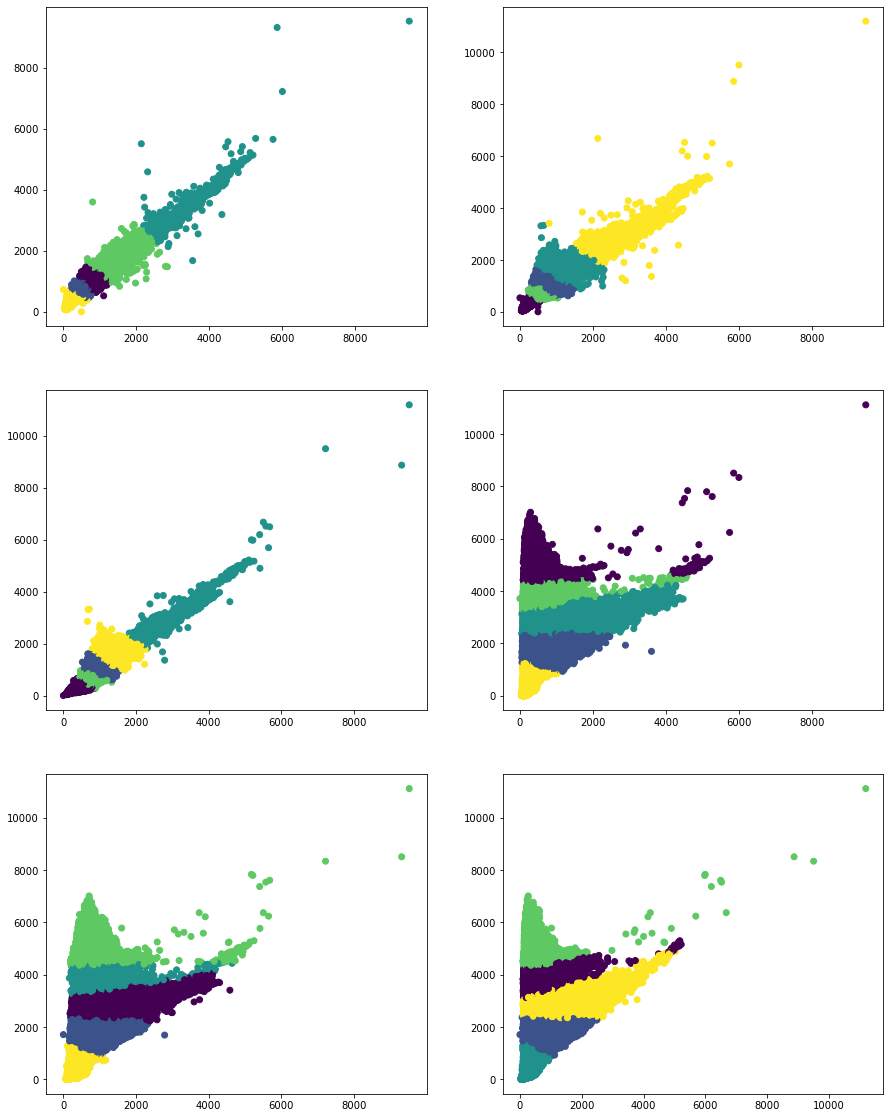

In [15]:
fig = plt.figure (figsize = (15,20))
ay1 = fig.add_subplot(3,2,1)
ay2 = fig.add_subplot(3,2,2)
ay3 = fig.add_subplot(3,2,3)
ay4 = fig.add_subplot(3,2,4)
ay5 = fig.add_subplot(3,2,5)
ay6 = fig.add_subplot(3,2,6)
ay1.scatter(b2_1d, b3_1d, c=kw23)
ay2.scatter(b2_1d, b4_1d, c=kw24)
ay3.scatter(b3_1d, b4_1d, c=kw34)
ay4.scatter(b2_1d, b8_1d, c=kw28)
ay5.scatter(b3_1d, b8_1d, c=kw38)
ay6.scatter(b4_1d, b8_1d, c=kw48)
plt.show()

## Pearson Correlation Between 2 Bands (10 m Resolution)
The results of pearson correlation shown that the lowest value is between bands 3 - 8 (almost 0) meanwhile combination between bands 2-3, 2-4, and 3-4 had the highest pearson correlation value (almost 1, the same as 60 m).Two bands had negative correlations, namely the bands 2-8 and bands 4-8, that means there is no correlation between these bands. Finally, the band 3-8 noticed very low value, almost zero, so we can also assume that there is also no correlation between these bands.

In [ ]:
from scipy import stats

b2_1d_n = (b2_1d - b2_1d.mean())/b2_1d.std()
b3_1d_n = (b3_1d - b3_1d.mean())/b3_1d.std()
b4_1d_n = (b4_1d - b4_1d.mean())/b4_1d.std()
b8_1d_n = (b8_1d - b8_1d.mean())/b8_1d.std()

pecoef_23 = stats.pearsonr(b2_1d_n,b3_1d_n)
pecoef_24 = stats.pearsonr(b2_1d_n,b4_1d_n)
pecoef_34 = stats.pearsonr(b3_1d_n,b4_1d_n)
pecoef_28 = stats.pearsonr(b2_1d_n,b8_1d_n)
pecoef_38 = stats.pearsonr(b3_1d_n,b8_1d_n)
pecoef_48 = stats.pearsonr(b4_1d_n,b8_1d_n)

print ("pearson correlation band 2-band 3 :", pecoef_23)
print ("pearson correlation band 2-band 4 :", pecoef_24)
print ("pearson correlation band 3-band 4 :", pecoef_34)
print ("pearson correlation band 2-band 8 :", pecoef_28)
print ("pearson correlation band 3-band 8 :", pecoef_38)
print ("pearson correlation band 4-band 8 :", pecoef_48)

## Display Clustered Image of K-means Value (10 m Resolution)
Order to read the figures from left to right, first row bands 2-3, band 2-4, second row : bands 3-4, bands 2-8, third row : bands 3-8, bands 4-8.

At this step,the same procedure as 60 m resolution was used, but we were focused only in 5 clusters.

From the image, it was shown that the best visualisation is derived from the combination between primary colour band (bands 2,3,4) and NIR band (band 8). If we compare to the google image, the shape looklike a triangle is a Zoetermeerse Plas Lake. Around this lake there are several small lakes and irrigation channels. If we take a look on the first three images (bands 2-3, bands 2-4 and bands 3-4), the water area (small lakes, irrigation channels and etc) overlaps the land/grass area. Therefore it was assumed that bands 2-8, 3-8 and 4-8 gave a better result. This is also consistent with the pearson correlation value above. 

If we want to evaluate the results precisely, we have to validate the data by using the error matrix.

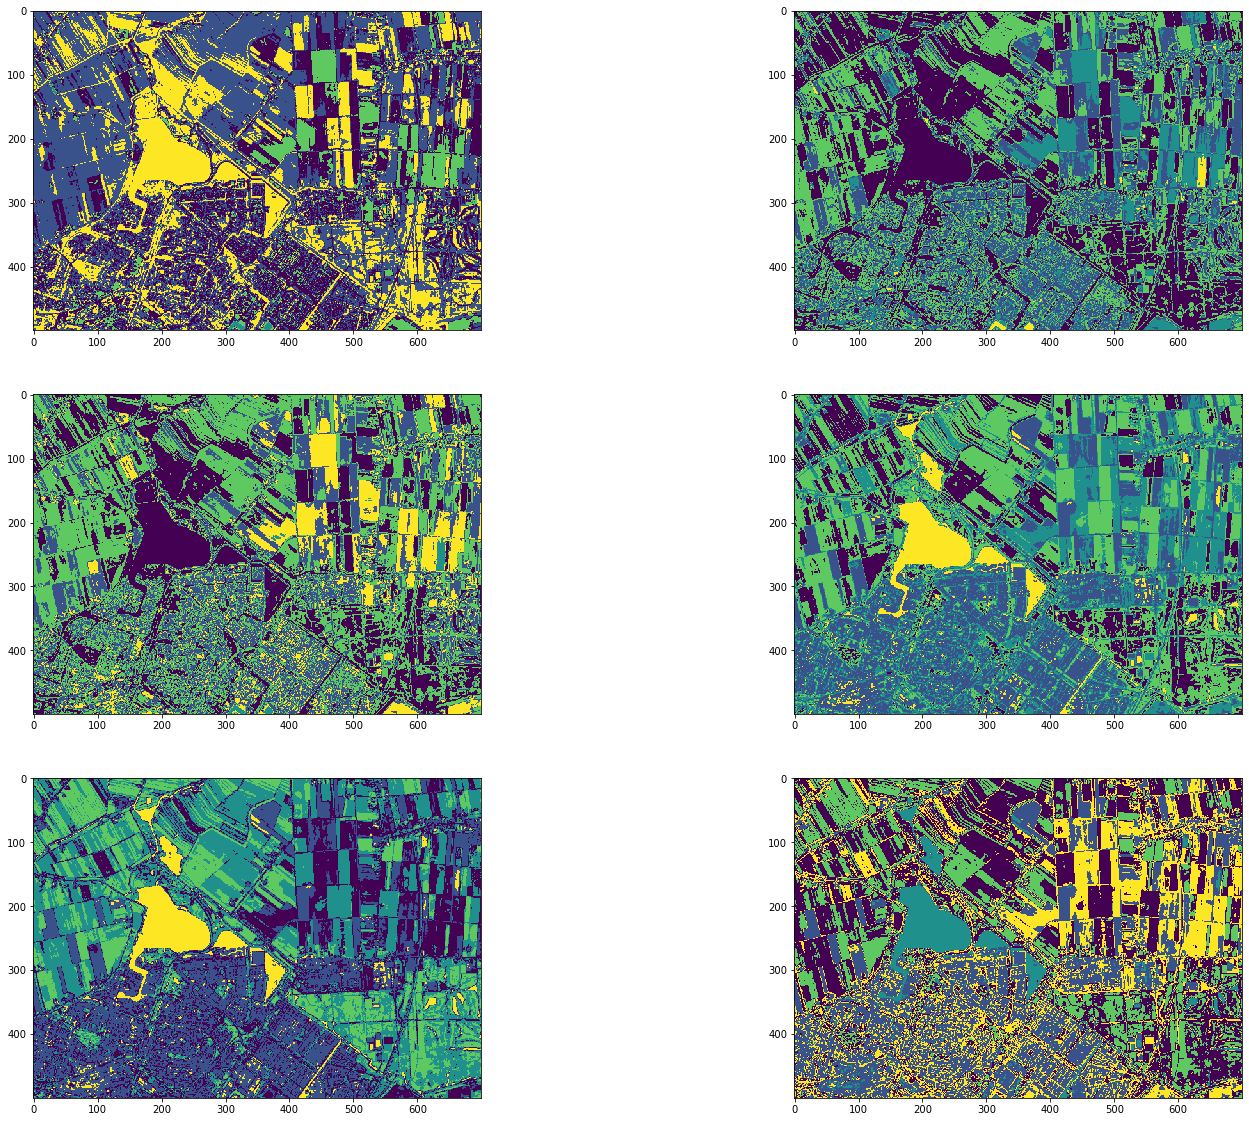

In [16]:
fig = plt.figure(figsize = (25,20))
ax1 = fig.add_subplot(3,2,1)
ax1.imshow(z23)
ax2 = fig.add_subplot(3,2,2)
ax2.imshow(z24)
ax3 = fig.add_subplot(3,2,3)
ax3.imshow(z34)
ax4 = fig.add_subplot(3,2,4)
ax4.imshow(z28)
ax5 = fig.add_subplot(3,2,5)
ax5.imshow(z38)
ax6 = fig.add_subplot(3,2,6)
ax6.imshow(z48)
plt.show()

## CDF Between 2 Bands (10 m Resolution)
This CDF plot showing the distribution of the data between two combination bands. The plot is pretty similar between each band combination.

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


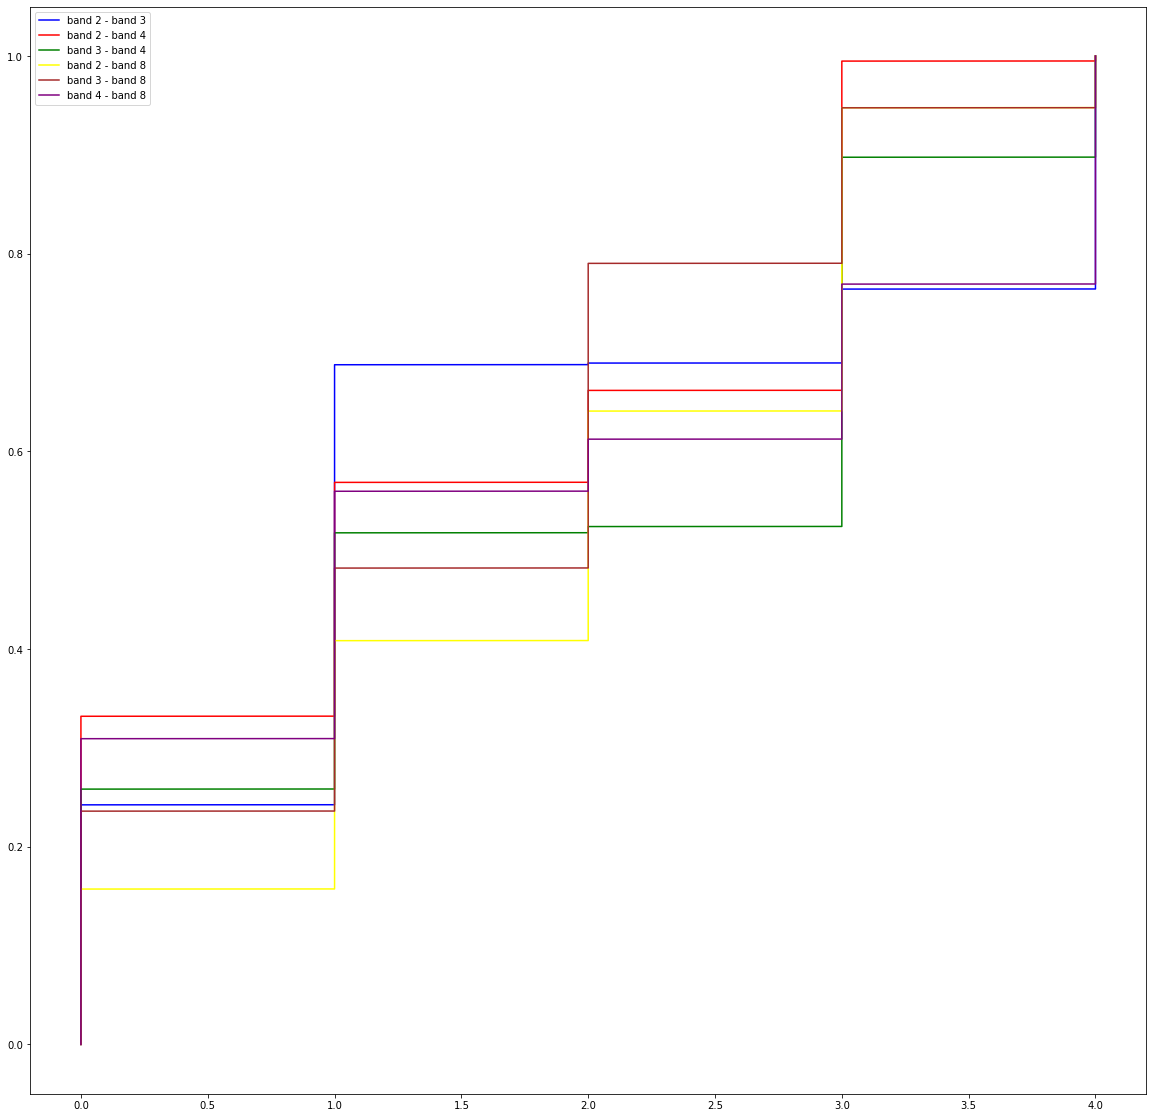

In [18]:
z23 = z23.flatten('F')
z23 = np.sort(z23)
a = 1. * np.arange(len(z23))/(len(z23) - 1)

z24 = z24.flatten('F')
z24 = np.sort(z24)
b = 1. * np.arange(len(z24))/(len(z24) - 1)

z34 = z34.flatten('F')
z34 = np.sort(z34)
c = 1. * np.arange(len(z34))/(len(z34) - 1)

z28 = z28.flatten ('F')
z28 = np.sort(z28)
d = 1. * np.arange(len(z28))/(len(z28) - 1)

z38 = z38.flatten ('F')
z38 = np.sort(z38)
e = 1. * np.arange(len(z38))/(len(z38) - 1)

z48 = z48.flatten ('F')
z48 = np.sort(z48)
f = 1. * np.arange(len(z48))/(len(z48) - 1)

plt.figure (figsize = (20,20))
plt.plot(z23, a, c= 'blue', label = 'band 2 - band 3')
plt.plot(z24, b, c= 'red', label = 'band 2 - band 4')
plt.plot(z34, c, c= 'green', label = 'band 3 - band 4')
plt.plot(z28, d, c= 'yellow', label = 'band 2 - band 8')
plt.plot(z38, e, c= 'brown', label = 'band 3 - band 8')
plt.plot(z48, f, c= 'purple', label = 'band 4 - band 8')
plt.legend()
plt.show()

## Conclusion

To sum up, the use of false colours is needed to visualize wavelengths the human eye does not see. The use of band 8 (near the infared range) and band 11 (short wave infrared) increase the spectral seperation and can enchance the interpretability of data. In addition, it was concludedn that there is no perfect bands combination in general but it depends on the objects that we want to analyse. In other words, it is used different combination of bands to analyze the vegetation and others combinations for the roads. 